In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import cv2
from skimage import measure
from matplotlib.patches import Ellipse
import matplotlib.patheffects as pe

In [2]:
# HELPER FUNCTIONS
def display(img):
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def display_two(img1, img2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(img1)
    ax1.axis('off')
    
    ax2.imshow(img2)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

def downscale_image(image):
    """
    Downscale an image by 1/4 using linear interpolation.
    
    Args:
        image: Input image array
    
    Returns:
        numpy.ndarray: Downscaled image array
    """
    height, width = image.shape[:2]
    new_width = width // 4
    new_height = height // 4
    return cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

def load_image(image_path):
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    return image_rgb

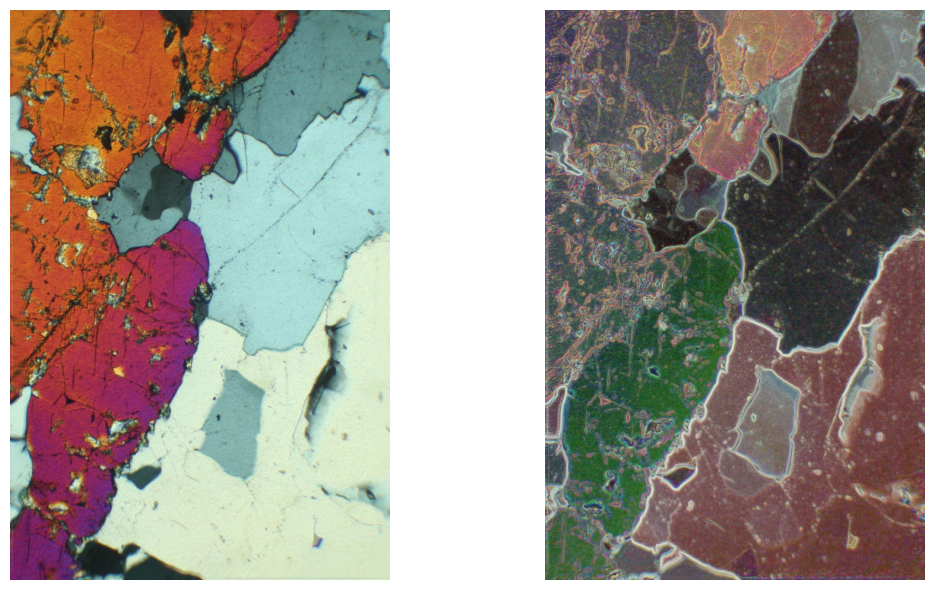

In [3]:
# Load the images
composite = downscale_image(load_image('./thin-sections/8a/8a_composite.jpg'))
beauty = downscale_image(load_image('./thin-sections/8a/8a_beauty.jpg'))
lin = downscale_image(load_image('./thin-sections/8a/8a_lin.jpg'))

display_two(composite, beauty)

In [4]:
# Apply bilateral filter twice to each image
composite = cv2.bilateralFilter(composite, d=9, sigmaColor=75, sigmaSpace=75)
composite = cv2.bilateralFilter(composite, d=9, sigmaColor=75, sigmaSpace=75)

beauty = cv2.bilateralFilter(beauty, d=9, sigmaColor=75, sigmaSpace=75)
beauty = cv2.bilateralFilter(beauty, d=9, sigmaColor=75, sigmaSpace=75)

lin = cv2.bilateralFilter(lin, d=9, sigmaColor=75, sigmaSpace=75)
lin = cv2.bilateralFilter(lin, d=9, sigmaColor=75, sigmaSpace=75)

In [51]:
def preprocess_image_with_coordinates(composite, beauty, lin):
    h, w, c = composite.shape
    composite_pixels = composite.reshape(-1, 3)
    beauty_pixels = beauty.reshape(-1, 3)
    lin_pixels = lin.reshape(-1, 3)
    
    coords = np.indices((h, w)).reshape(2, -1).T
    
    features = np.hstack((composite_pixels, beauty_pixels, lin_pixels, coords))
    return features

features = preprocess_image_with_coordinates(composite, beauty, lin)
print("Features shape:", features.shape)

Features shape: (375000, 11)


In [56]:
def apply_gmm(features, n_clusters):
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
    gmm.fit(features)
    labels = gmm.predict(features)
    proportions = [np.sum(labels == i) / len(labels) for i in range(n_clusters)]
    return labels, gmm, proportions

# Apply GMM
n_clusters = 8
labels, gmm, proportions = apply_gmm(features, n_clusters)

print("Labels shape:", labels.shape)
print("Number of clusters:", n_clusters)
print("Cluster proportions:", proportions)

Labels shape: (375000,)
Number of clusters: 8
Cluster proportions: [np.float64(0.12884266666666666), np.float64(0.09293333333333334), np.float64(0.11805333333333333), np.float64(0.07792266666666667), np.float64(0.17529866666666666), np.float64(0.15131466666666665), np.float64(0.056552), np.float64(0.19908266666666666)]


In [53]:
def overlay_contours(image, labels, n_clusters, cluster_colors):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for i in range(n_clusters):
        mask = labels.reshape(image.shape[:2]) == i
        contours = measure.find_contours(mask, 0.5)
        color = cluster_colors[i] / 255.0
        for contour in contours:
            plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
    plt.title('Cluster Boundaries Overlay with Cluster Colors')
    plt.axis('off')
    plt.show()

def overlay_cluster_ellipses(image, gmm, n_clusters):
    h, w, _ = image.shape
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    colors = gmm.means_[:, :3] / 255.0

    for i in range(n_clusters):
        x_mean, y_mean = gmm.means_[i, 4], gmm.means_[i, 3]
        covariances = gmm.covariances_[i] if gmm.covariance_type != 'tied' else gmm.covariances_
        covar = covariances[3:5, 3:5]
        eigenvalues, eigenvectors = np.linalg.eigh(covar)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
        width, height = 2 * np.sqrt(eigenvalues)
        ellipse = Ellipse(xy=(x_mean, y_mean), width=width, height=height, angle=angle,
                          edgecolor=colors[i], fc='none', lw=2)
        ax.add_patch(ellipse)
        ax.text(x_mean, y_mean, f'{i+1}', color='white', fontsize=12, ha='center', va='center')

    ax.set_title('Cluster Ellipses Overlay')
    ax.axis('off')
    plt.show()

Segmented image saved as 'segmented_image.png'.


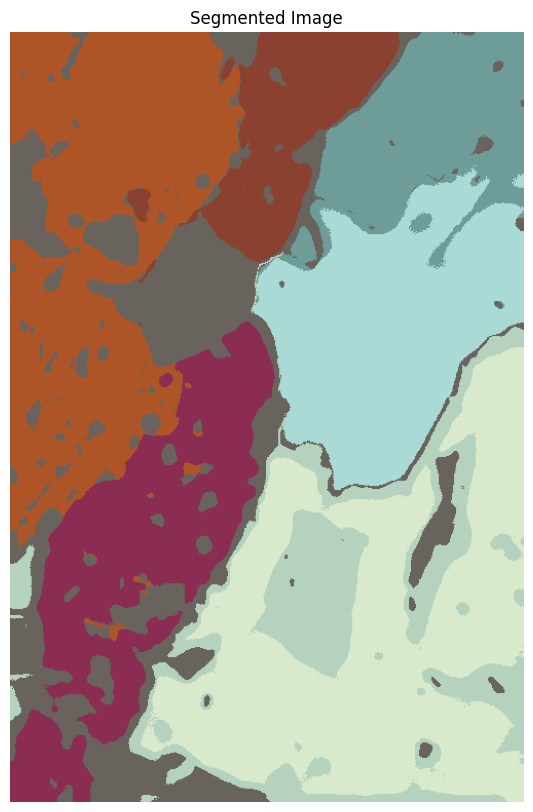

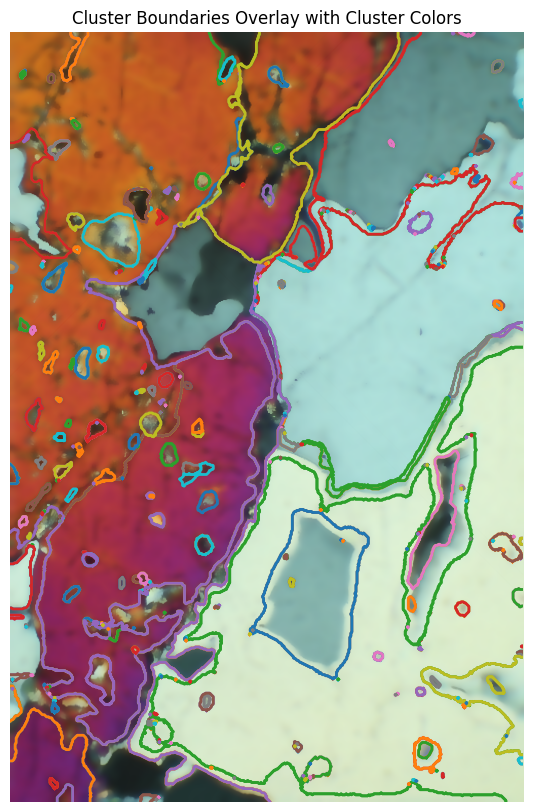

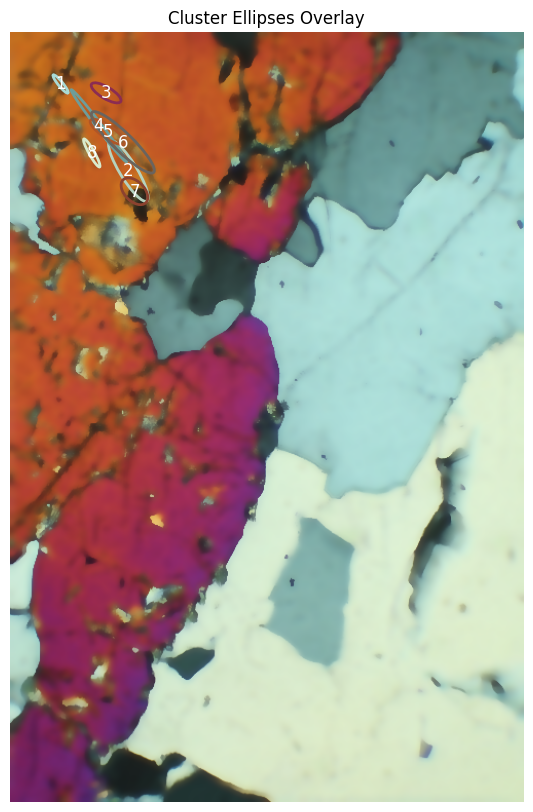

In [54]:
def visualize_results(image, labels, gmm, proportions, n_clusters):
    # Reshape labels to image dimensions
    segmented_image = labels.reshape(image.shape[:2])

    # Extract only RGB components for visualization
    centers = gmm.means_
    cluster_colors = centers[:, :3]

    # Create an RGB image where each pixel is colored by its cluster
    segmented_rgb = cluster_colors[segmented_image].reshape(image.shape)

    # Save the Segmented Image
    segmented_bgr = cv2.cvtColor(segmented_rgb.astype(np.uint8), cv2.COLOR_RGB2BGR)
    cv2.imwrite('segmented_image.png', segmented_bgr)
    print("Segmented image saved as 'segmented_image.png'.")

    # Display the segmented image
    plt.figure(figsize=(10, 10))
    plt.imshow(segmented_rgb.astype(np.uint8))
    plt.title('Segmented Image')
    plt.axis('off')
    plt.show()

    # Overlay Cluster Boundaries
    overlay_contours(image, labels, n_clusters, cluster_colors)

    # Overlay Cluster Centroids with Ellipses
    overlay_cluster_ellipses(image, gmm, n_clusters)

# Visualize the results
visualize_results(filtered_image, labels, gmm, proportions, n_clusters)